In [77]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

def warn(*args, **kwargs):
    pass
warnings.warn = warn

import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [103]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_all_1043_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_1043_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_1043_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### AdaBoostClassifier

In [104]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=100)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {'base_estimator__max_depth':[10,20],
              'base_estimator__min_samples_leaf':[5,7],
              'n_estimators':[60,70],
              'learning_rate':[0.01,0.01]}

grid = GridSearchCV(ab, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

warnings.simplefilter(action='ignore', category=FutureWarning) 
grid.fit(X_train_interp, y_train) # takes upto 5mins

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mini

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise',
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=100),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [10, 20],
                         'base_estimator__min_samples_leaf': [5, 7],
                         'learning_rate': [0.01, 0.01],
                         'n_estimators': [60, 70]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [105]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'base_estimator__max_depth': 20, 'base_estimator__min_samples_leaf': 7, 'learning_rate': 0.01, 'n_estimators': 60}
Best estimator is: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20,
                                                    min_samples_leaf=7),
                   learning_rate=0.01, n_estimators=60, random_state=100)
Best Validation accuracy is: 0.6403289805930308


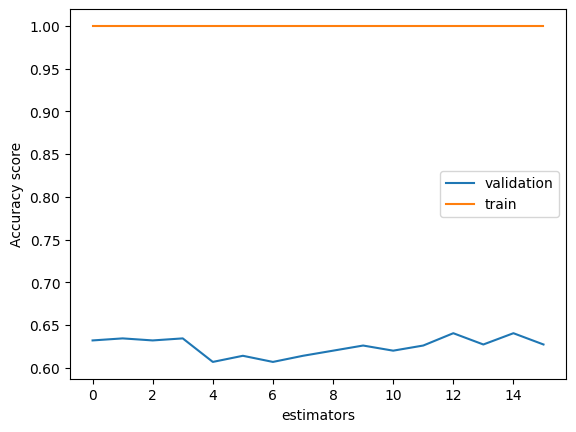

In [106]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [107]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.6555


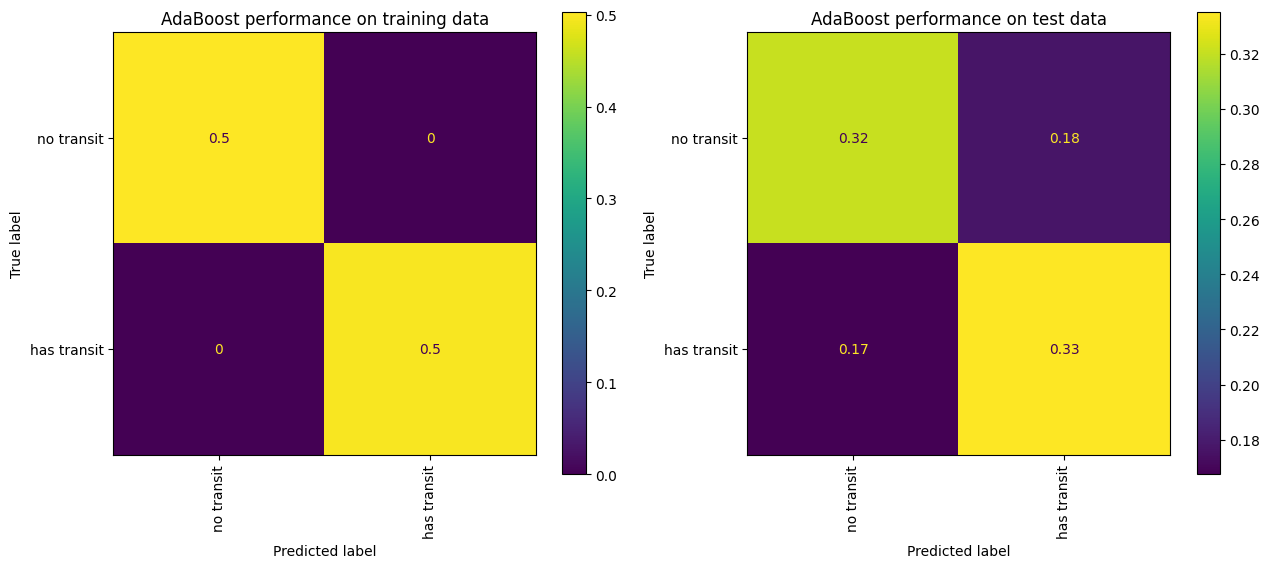

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       104
           1       0.65      0.67      0.66       105

    accuracy                           0.66       209
   macro avg       0.66      0.66      0.66       209
weighted avg       0.66      0.66      0.66       209

Recall score is 0.6666666666666666
Validation Data:
	 Accuracy 1.0
	 Precision 1.0
	 Recall 1.0
	 F1 1.0
Test Data:
	 Accuracy 0.656
	 Precision 0.654
	 Recall 0.667
	 F1 0.66


In [108]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(grid, X_train_interp, y_train, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('AdaBoost performance on training data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('AdaBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

print("Validation Data:")
print(f"\t Accuracy {round(accuracy_score(y_train, svc_pred_train), 3)}")
print(f"\t Precision {round(precision_score(y_train, svc_pred_train),3)}")
print(f"\t Recall {round(recall_score(y_train, svc_pred_train),3)}")
print(f"\t F1 {round(f1_score(y_train, svc_pred_train),3)}")
print("Test Data:")
print(f"\t Accuracy {round(accuracy_score(y_test, svc_pred_test),3)}")
print(f"\t Precision {round(precision_score(y_test, svc_pred_test),3)}")
print(f"\t Recall {round(recall_score(y_test, svc_pred_test),3)}")
print(f"\t F1 {round(f1_score(y_test, svc_pred_test),3)}")

## Use Phase-folded smooth data 

In [109]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_phase_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### AdaBoostClassifier

In [110]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=100)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {'base_estimator__max_depth':[10,20],
              'base_estimator__min_samples_leaf':[5,7],
              'n_estimators':[60,70],
              'learning_rate':[0.01,0.01]}

grid = GridSearchCV(ab, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

warnings.simplefilter(action='ignore', category=FutureWarning) 
grid.fit(X_train_interp, y_train) # takes upto 5mins

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mini

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise',
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=100),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [10, 20],
                         'base_estimator__min_samples_leaf': [5, 7],
                         'learning_rate': [0.01, 0.01],
                         'n_estimators': [60, 70]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [111]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 70}
Best estimator is: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_samples_leaf=5),
                   learning_rate=0.01, n_estimators=70, random_state=100)
Best Validation accuracy is: 0.74875


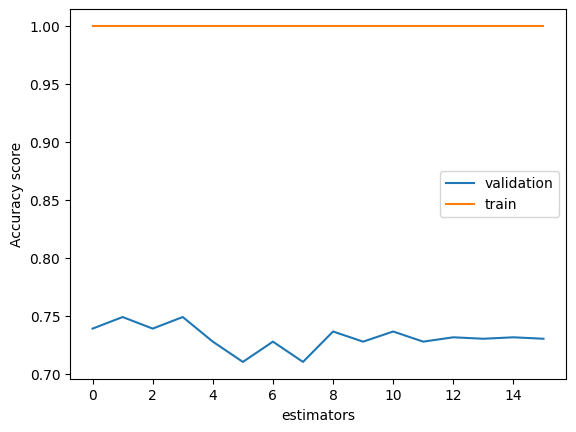

In [112]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [113]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.755


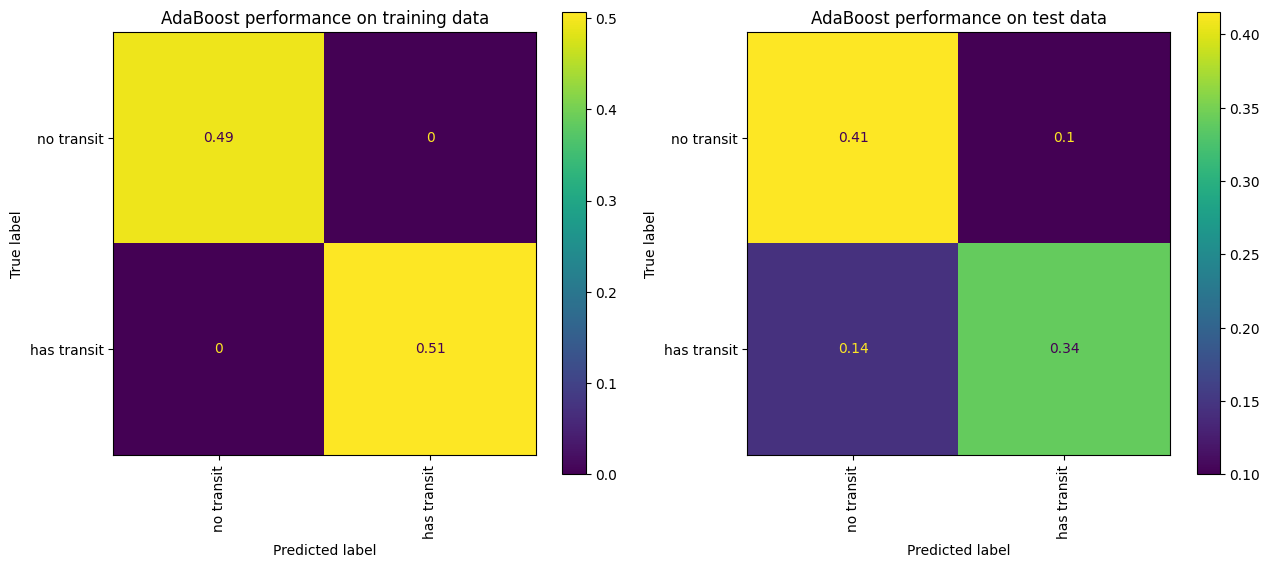

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       103
           1       0.77      0.70      0.74        97

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.75       200

Recall score is 0.7010309278350515
Validation Data:
	 Accuracy 1.0
	 Precision 1.0
	 Recall 1.0
	 F1 1.0
Test Data:
	 Accuracy 0.755
	 Precision 0.773
	 Recall 0.701
	 F1 0.735


In [114]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(grid, X_train_interp, y_train, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('AdaBoost performance on training data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('AdaBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

print("Validation Data:")
print(f"\t Accuracy {round(accuracy_score(y_train, svc_pred_train), 3)}")
print(f"\t Precision {round(precision_score(y_train, svc_pred_train),3)}")
print(f"\t Recall {round(recall_score(y_train, svc_pred_train),3)}")
print(f"\t F1 {round(f1_score(y_train, svc_pred_train),3)}")
print("Test Data:")
print(f"\t Accuracy {round(accuracy_score(y_test, svc_pred_test),3)}")
print(f"\t Precision {round(precision_score(y_test, svc_pred_test),3)}")
print(f"\t Recall {round(recall_score(y_test, svc_pred_test),3)}")
print(f"\t F1 {round(f1_score(y_test, svc_pred_test),3)}")

## GradientBoostingClassifier

In [115]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_all_1043_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_1043_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_1043_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

In [116]:
gbc = GradientBoostingClassifier(random_state=100)

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5,7, 10],
    "max_depth":[5,10,20,30],
    "max_features":["log2","sqrt"],
    "n_estimators":[100, 125, 150]
}

grid = GridSearchCV(gbc, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

grid.fit(X_train_interp, y_train) # takes upto 10mins

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise',
             estimator=GradientBoostingClassifier(random_state=100), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [5, 10, 20, 30],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': [100, 125, 150]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [117]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
Best estimator is: GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=5, n_estimators=150,
                           random_state=100)
Best Validation accuracy is: 0.6739672977624785


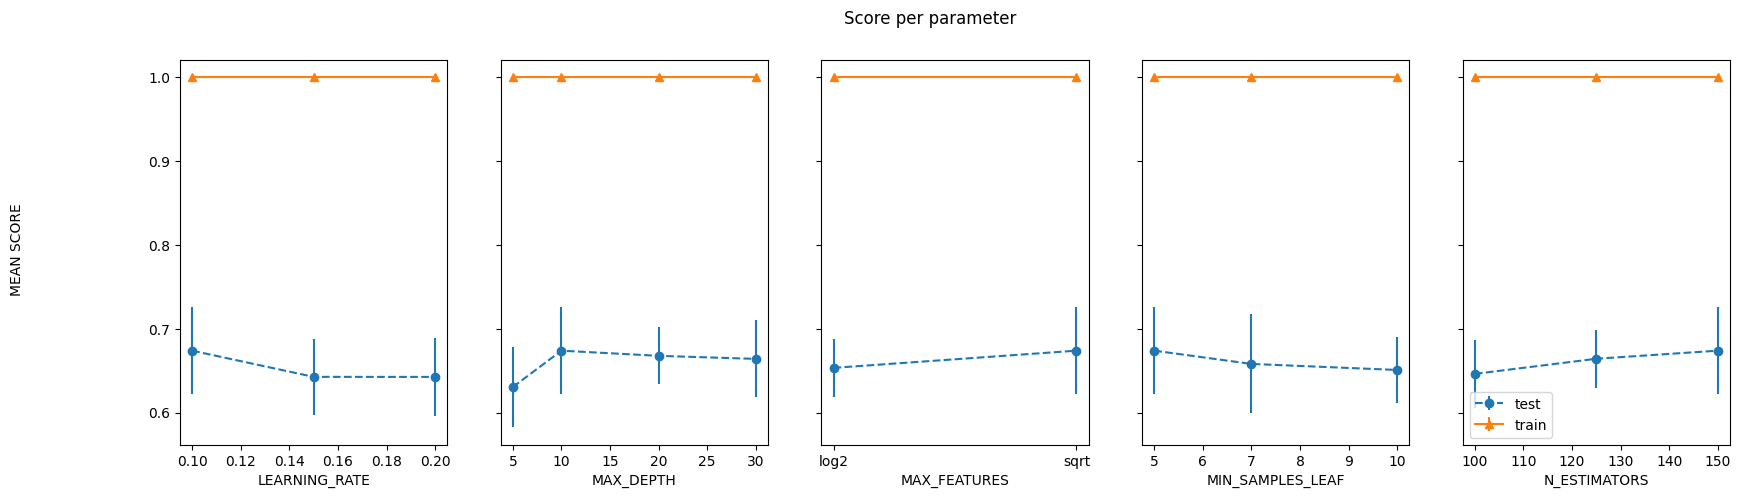

In [118]:
results = grid.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

## Getting indexes of values per hyper-parameter
masks=[]
masks_names= list(grid.best_params_.keys())
for p_k, p_v in grid.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params=grid.param_grid

## Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

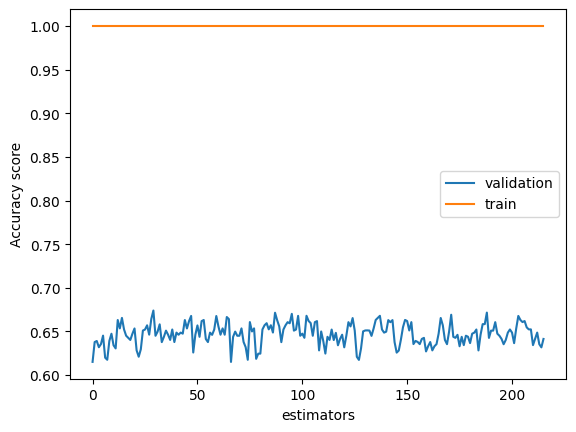

In [119]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [120]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.7177


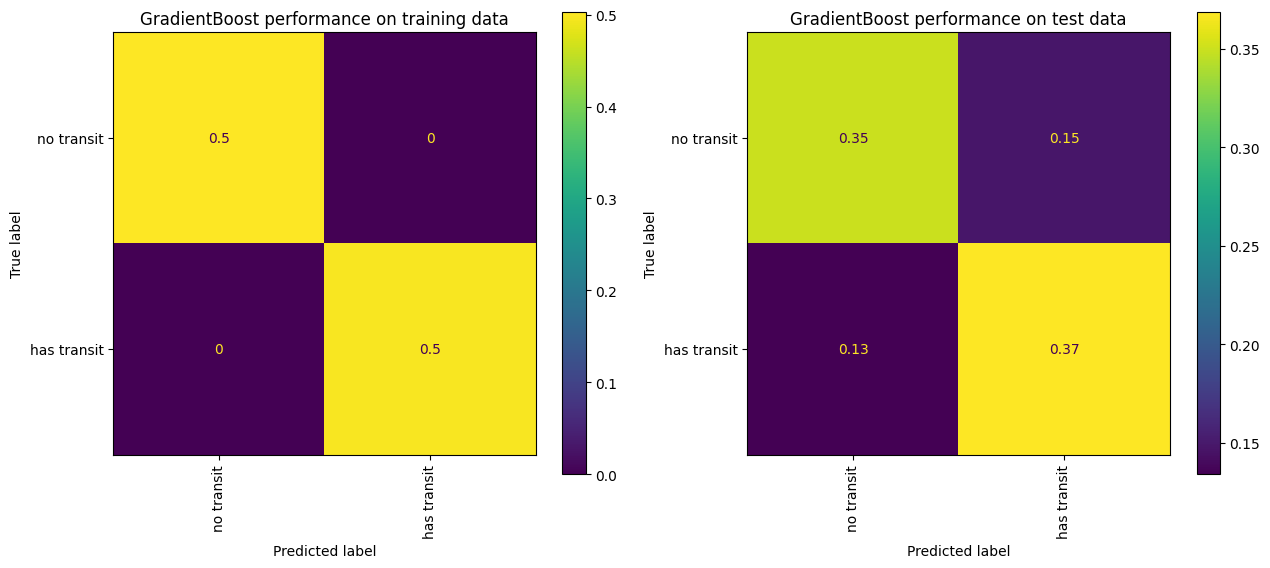

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       104
           1       0.71      0.73      0.72       105

    accuracy                           0.72       209
   macro avg       0.72      0.72      0.72       209
weighted avg       0.72      0.72      0.72       209

Recall score is 0.7333333333333333
Validation Data:
	 Accuracy 1.0
	 Precision 1.0
	 Recall 1.0
	 F1 1.0
Test Data:
	 Accuracy 0.718
	 Precision 0.713
	 Recall 0.733
	 F1 0.723


In [121]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(grid, X_train_interp, y_train, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('GradientBoost performance on training data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('GradientBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

print("Validation Data:")
print(f"\t Accuracy {round(accuracy_score(y_train, svc_pred_train), 3)}")
print(f"\t Precision {round(precision_score(y_train, svc_pred_train),3)}")
print(f"\t Recall {round(recall_score(y_train, svc_pred_train),3)}")
print(f"\t F1 {round(f1_score(y_train, svc_pred_train),3)}")
print("Test Data:")
print(f"\t Accuracy {round(accuracy_score(y_test, svc_pred_test),3)}")
print(f"\t Precision {round(precision_score(y_test, svc_pred_test),3)}")
print(f"\t Recall {round(recall_score(y_test, svc_pred_test),3)}")
print(f"\t F1 {round(f1_score(y_test, svc_pred_test),3)}")

## Use Phase-folded smooth data 

In [122]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_phase_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

In [123]:
gbc = GradientBoostingClassifier(random_state=100)

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5,7, 10],
    "max_depth":[5,10,20,30],
    "max_features":["log2","sqrt"],
    "n_estimators":[100, 125, 150]
}

grid = GridSearchCV(gbc, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

grid.fit(X_train_interp, y_train) # takes upto 10mins

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise',
             estimator=GradientBoostingClassifier(random_state=100), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [5, 10, 20, 30],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': [100, 125, 150]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [124]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'learning_rate': 0.15, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
Best estimator is: GradientBoostingClassifier(learning_rate=0.15, max_depth=30,
                           max_features='sqrt', min_samples_leaf=5,
                           n_estimators=150, random_state=100)
Best Validation accuracy is: 0.78375


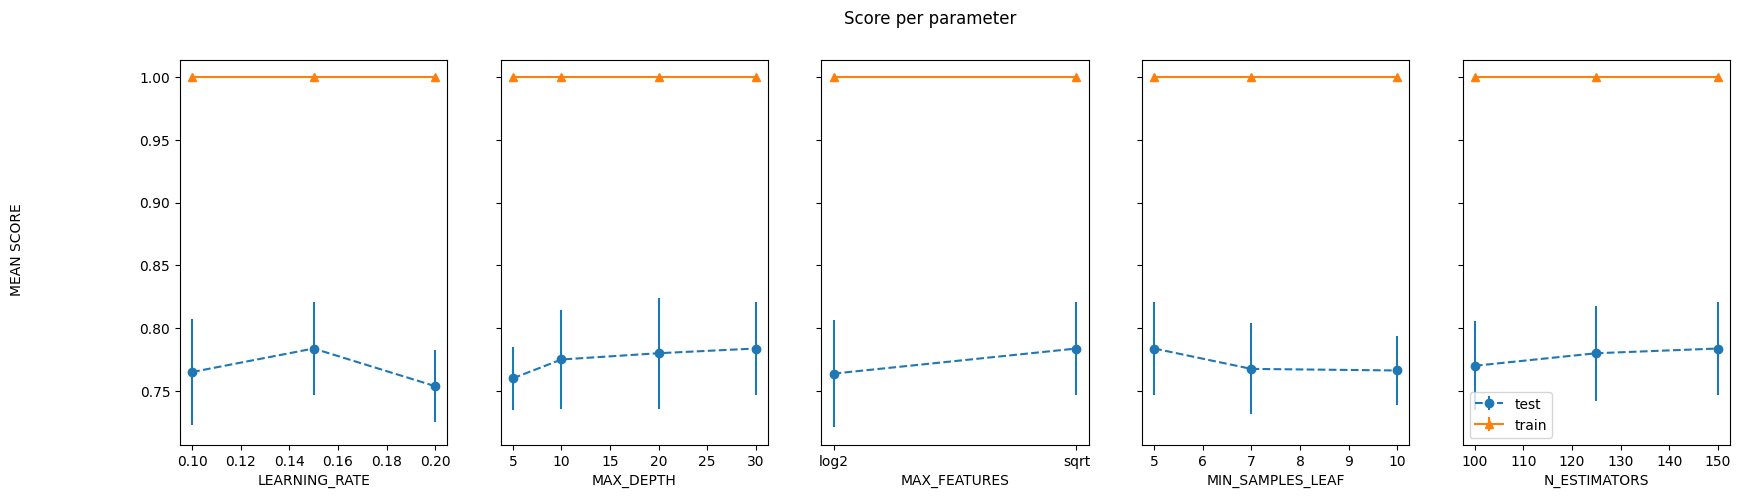

In [125]:
results = grid.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

## Getting indexes of values per hyper-parameter
masks=[]
masks_names= list(grid.best_params_.keys())
for p_k, p_v in grid.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params=grid.param_grid

## Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

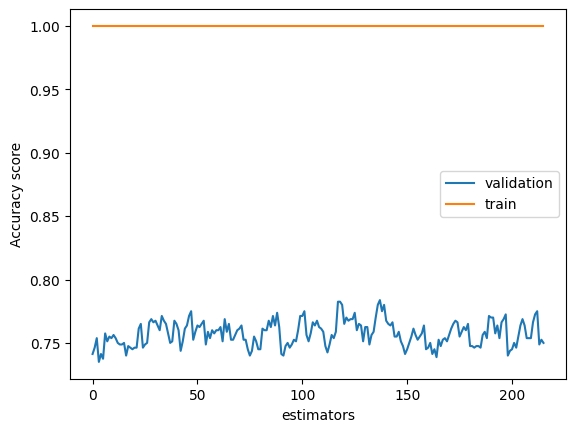

In [126]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [127]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.77


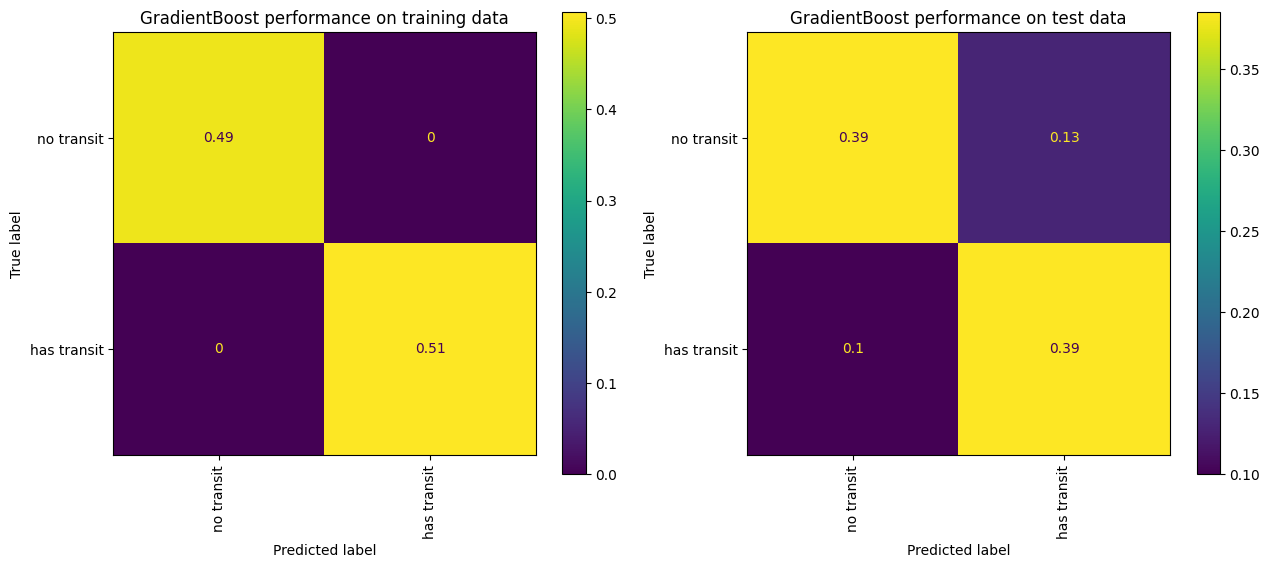

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       103
           1       0.75      0.79      0.77        97

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Recall score is 0.7938144329896907
Validation Data:
	 Accuracy 1.0
	 Precision 1.0
	 Recall 1.0
	 F1 1.0
Test Data:
	 Accuracy 0.77
	 Precision 0.748
	 Recall 0.794
	 F1 0.77


In [128]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(grid, X_train_interp, y_train, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('GradientBoost performance on training data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'])
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('GradientBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

print("Validation Data:")
print(f"\t Accuracy {round(accuracy_score(y_train, svc_pred_train), 3)}")
print(f"\t Precision {round(precision_score(y_train, svc_pred_train),3)}")
print(f"\t Recall {round(recall_score(y_train, svc_pred_train),3)}")
print(f"\t F1 {round(f1_score(y_train, svc_pred_train),3)}")
print("Test Data:")
print(f"\t Accuracy {round(accuracy_score(y_test, svc_pred_test),3)}")
print(f"\t Precision {round(precision_score(y_test, svc_pred_test),3)}")
print(f"\t Recall {round(recall_score(y_test, svc_pred_test),3)}")
print(f"\t F1 {round(f1_score(y_test, svc_pred_test),3)}")

# Trying out Feature selection using RFE and SelectKBest

In [65]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_phase_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

In [75]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
# hyper_params = [{'n_features_to_select': [500,750,900]}]
hyper_params = [{'n_features_to_select': [500]}]



selector = SelectKBest(f_classif, k=850) # test - 57.5
selector.fit(X_train_interp, y_train)
print('Number of input features:', selector.n_features_in_)

X_train_selected = selector.transform(X_train_interp)
X_test_selected = selector.transform(X_test_interp)

folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10, min_samples_leaf=5),
                   learning_rate=0.01, n_estimators=70, random_state=100)
model.fit(X_train_selected, y_train)
# takes too long 
# rfe = RFE(model)

# model_cv2 = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'accuracy', cv = folds,  verbose = 1, return_train_score=True, n_jobs=-1) 
# model_cv2.fit(X_train_interp, y_train)

Number of input features: 1000


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_samples_leaf=5),
                   learning_rate=0.01, n_estimators=70, random_state=100)

In [76]:
svc_pred_test = model.predict(X_test_selected)
svc_pred_train = model.predict(X_train_selected)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.73
